# MECANISMO CUATRO BARRAS 

## PROBLEMAS VELOCIDAD Y ACELERACIÓN

### PASO 1: MATRIZ JACOBIANA 

Para resolver el problema velocidad, necesitamos otra vez la matriz jacobiana. El método de construcción aparece detallado en el notebook Problema_Posición_4B, por lo que para este caso copiaremos el código de los pasos realizados para poder conseguirla.

In [1]:
#PASO 1
import numpy as np
import math as math
#import array as arr
import pprint  
import matplotlib.pyplot as plt  
import matplotlib.animation as animation
import scipy.integrate as integrate 
import os
from time import sleep
%matplotlib inline  


print ('MECANISMO DE CUATRO BARRAS')
print ('=============================')
# Lectura de datos por teclado

meca = {} # dictionary vacio, con propiedades de mecanismo

meca["L1"] = float (input ('Introduce longitud L1:'))
meca["L2"] = float (input ('Introduce longitud L2:'))
meca["L3"] = float (input ('Introduce longitud L3:'))
meca["theta"] = float (input ('Introduce angulo inicial theta:')) #En rad
meca["XB"] = float (input ('Introduce coordenada en x del punto B:'))
meca["XA"] = 0
meca["YA"] = 0
meca["YB"] = 0

# Defino posicion inicial:
q = np.array ([[0.1], [meca["L1"]], [1], [0.2], [meca["theta"]]])
#print('q: ' + str(q))

a = meca["XB"] - meca ["XA"] 
b = meca["L1"]
c = meca["L2"]
d = meca["L3"]

ListaDeLongitudes = [d, c, b, a]

def ordenar(lista):
    
    for x in range (1, len(lista)):
        for y in range(len(lista)-1):
            if lista[y] < lista[y+1]:
                aux = lista[y]
                lista[y] = lista[y+1]
                lista[y+1] = aux
                
ordenar(ListaDeLongitudes)


print(ListaDeLongitudes)

a = (ListaDeLongitudes[3])
b = (ListaDeLongitudes[2])
c = (ListaDeLongitudes[1])
d = (ListaDeLongitudes[0])

if ((b+c)<(a+d)):
    print ("No cumple la desigualdad de Grashoff, por lo que la simulación no se ejecutará correctamente.")
# JACOBIANO
def jacob_Phiq(q,meca):
    #Inicializa a cero la matriz jacobiana
    Jacob = np.zeros((5,5))

    #Extraer coordenadas

    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]

    #Montar matriz

    Jacob[0,0] = 2*X1
    Jacob[0,1] = 2*Y1
    Jacob[1,0] = -2*(X2-X1)
    Jacob[1,1] = -2*(Y2-Y1)
    Jacob[1,2] = 2*(X2-X1)
    Jacob[1,3] = 2*(Y2-Y1)
    Jacob[2,2] = -2*(meca["XB"]-X2)
    Jacob[2,3] = 2*Y2

    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        Jacob[3,4] = meca["L1"]*math.sin(theta)
        Jacob[3,0] = 1
    else:
        Jacob[3,4] = -meca["L1"]*math.cos(theta)
        Jacob[3,1] = 1


    Jacob[4,4] = 1

    return Jacob


def Phi (q,meca):
    #Inicializa a cero Phi
    Phi = np.zeros((5,1))

    #Extraer coordenadas
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]

    Phi[0] = X1**2 + Y1**2 - meca["L1"]**2
    Phi[1] = (X2-X1)**2 + (Y2-Y1)**2 -meca["L2"]**2
    Phi[2] = (meca["XB"]-X2)**2 + Y2**2 - meca["L3"]**2

    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        Phi[3] = X1-meca["L1"]*math.cos(theta)
    else: 
        Phi[3] = Y1-meca["L1"]*math.sin(theta)

    return Phi



def resuelve_prob_posicion(q_init, meca):
    #Inicializacion de variables
    error = 1e10
    tolerancia = 1e-10

    #Inicializacion en cero de deltaQ, fi y q
    deltaQ = np.zeros ((5,1))
    q = q_init
    i=0

    # Iteraciones hasta conseguir que el error sea menor que la tolerancia

    while (error > tolerancia and i<=100):
        #print("q=")
        #pprint.pprint(q)


        #Extraer las coordenadas
        X1 = q[0]
        Y1 = q[1]
        X2 = q[2]
        Y2 = q[3]
        theta = q[4]
       
        fi=Phi(q,meca)
        #print ("Phi" + "=")
        #pprint.pprint(fi)
        J = jacob_Phiq(q,meca)
        #print ("jacob" + "=")
        #pprint.pprint(J)
        #rango = np.linalg.matrix_rank(J, 1e-5)
        #print("rango=" + str(rango) + "\n") #Si el rango es menor que el numero de filas no tiene solucion
        
        deltaQ = np.linalg.solve(J,-fi)
        q = q + deltaQ
        error = np.linalg.norm(deltaQ)  # El error es el modulo del vector
        i=i+1

        
        #print("error iter" + str(i) + "=")
        #pprint.pprint(error)
    #print("num iters:" + str(i))
    return q

q = resuelve_prob_posicion (q,meca)
J = jacob_Phiq(q,meca)
print ("Jacob=")
pprint.pprint(J)

MECANISMO DE CUATRO BARRAS
Introduce longitud L1:1
Introduce longitud L2:2
Introduce longitud L3:2.5
Introduce angulo inicial theta:0
Introduce coordenada en x del punto B:3
[3.0, 2.5, 2.0, 1.0]
Jacob=
array([[ 2.00000000e+00,  1.82578470e-31,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-8.75000000e-01,  3.90312375e+00,  8.75000000e-01,
        -3.90312375e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -3.12500000e+00,
        -3.90312375e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00]])


### PASO 2: PROBLEMA VELOCIDAD

Consiste en determinar las velocidades de todas las variables del mecanismo una vez sabemos su posición $q$ y la velocidad de los grados de libertad. 

Partimos de la ecuación:

$\Phi_q  =0 $

Derivando se obtiene:

$\Phi_q \dot{q} + \Phi_t = 0$

Siendo $\dot{q}$ el vector velocidad, $\Phi_q$ el jacobiano y $\Phi_t$ la derivada parcial de las ecuaciones de restricción respecto al tiempo. Para las ecuaciones de sólido rígido el valor de esta derivada es $0$. Solo tendría un valor no nulo la correspondiente al ángulo, que en ese caso tendría la velocidad que nosotros le indiquemos. 

De este modo la expresión quedaría:

$\Phi_q \dot{q} = -\Phi_t$

Este sistema de ecuaciones tiene infinitas soluciones y por tanto hay que ampliar añadiendo un dato conocido de velocidad, lo que se hace añadiendo una fila a la matriz de coeficientes del lado izquierdo y un dato a la columna del lado derecho de la ecuación por cada grado de libertad.

De esta forma llegamos a un sistema de ecuaciones lineal matricial de la forma:

$\mathbf{A} \mathbf{x} = \mathbf{b}$

Habría que multiplicar en ambas partes de la igualdad por la $A$ invertida en el lado izquierdo, del mismo modo que se hizo en el problema de posición. De esta manera quedaría:



$x = -A^{-1} b$

In [2]:
#PASO 2

def resuelve_prob_velocidad(q,qp,meca):
    qp = np.linalg.solve(jacob_Phiq(q,meca),qp)
    #print ("qp=")
    #pprint.pprint(qp)
 
    return qp

qp = np.zeros ((5,1))
#Velocidad del gdl. En una vuelta completa del angulo se cumple angulo=2*Pi*t
qp[4]=1

resuelve_prob_velocidad (q,qp, meca)

array([[-9.12892351e-32],
       [ 1.00000000e+00],
       [-9.75780937e-01],
       [ 7.81250000e-01],
       [ 1.00000000e+00]])

### PASO 3: PROBLEMA ACELERACIÓN

El problema aceleración trata de determinar las aceleraciones de todas las variables del mecanismo, conociendo la posición$q$, la velocidad $\dot{q}$ y las aceleraciones de los grados de libertad. 

Partimos la ecuación que se obtiene tras derivar la ecuación inicial para el problema de velocidad, es decir:

$\Phi_q \dot{q} + \Phi_t = 0$

Se deriva por segunda vez:

$\dot{\Phi}_q \dot{q} + \Phi_q \ddot{q} + \dot{\Phi}_t = 0$

Despejamos $\Phi_q \ddot{q}$:

$\Phi_q \ddot{q} = -\dot{\Phi}_t - \dot{\Phi}_q  \dot{q}$


Siendo $\Phi_q$ el jacobiano, $\ddot{q}$ el vector aceleración, $\dot{q}$ el vector velocidad, $\dot{\Phi}_q$ la derivada del jacobiano respecto al tiempo y $\dot{\Phi}_t$ es la derivada de las ecuaciones de restricción con respecto al tiempo, cuyo valor es nulo. Es decir, tendríamos:

$\Phi_q \ddot{q} = - \dot{\Phi}_q  \dot{q}$

Del mismo modo que en el problema velocidad, llamando $b$ al conjunto formado por $\dot{\Phi}_q  \dot{q}$  llegamos a un sistema de ecuaciones lineal matricial:

$ \mathbf{A} \mathbf{x} = \mathbf{b}$

Y despejando la $x$:

$\mathbf{x} = \mathbf{-A}^{-1} \mathbf{b}$


El vector velocidad será:

\begin{equation}
\mathbf{q_p} = 
\begin{bmatrix}
\dot{X}_1 \\
\dot{Y}_1\\
\dot{X}_2 \\
\dot{Y}_2 \\
\dot{\theta}\\
\end{bmatrix}
\end{equation}

Por otro lado, para calcular la derivada del jacobiano solo tenemos en cuenta las filas que hacen referencia a las ecuaciones de las coordenadas dependientes, ya que la última que añadimos para poder realizar los cálculos era adicional. Teniendo en cuenta esto, la derivada del jacobiano sería:

1. $Si ~~ \cos (\theta) < \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{\dot{\Phi}_q} = 
\begin{bmatrix}
2\dot{X}_1 & 2\dot{Y}_1 & 0 & 0 & 0  \\
-2(\dot{X}_2-\dot{X}_1) & -2(\dot{Y}_2-\dot{Y}_1) & 2(\dot{X}_2-\dot{X}_1) & 2(\dot{Y}_2-\dot{Y}_1) & 0\\
0 & 0 & 2\dot{X}_2 & 2\dot{Y}_2 & 0  \\
0 & 0 & 0 & 0 & \theta^2L_1\cos(\theta)\\
\end{bmatrix}
\end{equation}


1. $Si ~~ \cos (\theta) > \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{\dot{\Phi}_q} = 
\begin{bmatrix}
2\dot{X}_1 & 2\dot{Y}_1 & 0 & 0 & 0  \\
-2(\dot{X}_2-\dot{X}_1) & -2(\dot{Y}_2-\dot{Y}_1) & 2(\dot{X}_2-\dot{X}_1) & 2(\dot{Y}_2-\dot{Y}_1) & 0\\
0 & 0 & 2\dot{X}_2 & 2\dot{Y}_2 & 0  \\
0 & 0 & 0 & 0 & \theta^2L_1\sin(\theta)\\
\end{bmatrix}
\end{equation}


Como ya tenemos $\dot{\Phi}_q$ y $\dot{q}$, podemos calcular $b$. La última fila que añadimos es el valor de la aceleración angular, dato que sabemos de antemano. 


1. $Si ~~ \cos (\theta) < \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{b} = 
\begin{bmatrix}
2\dot{X}_1^2 + 2\dot{Y}_1^2\\
-2\dot{X}_1(\dot{X}_2-\dot{X}_1) - 2\dot{Y}_1(\dot{Y}_2-\dot{Y}_2) + 2\dot{X}_2(\dot{X}_2-\dot{X}_1) - 2\dot{Y}_2·(\dot{Y}_2-\dot{Y}_1)\\
2\dot{X}_2^2 + 2\dot{Y}_2^2 \\
\dot{\theta}^2·L_1·\cos(\theta)\\
1\\
\end{bmatrix}
\end{equation}

2. $Si ~~ \cos (\theta) > \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{b} = 
\begin{bmatrix}
2\dot{X}_1^2 + 2\dot{Y}_1^2\\
-2\dot{X}_1(\dot{X}_2-\dot{X}_1) - 2\dot{Y}_1(\dot{Y}_2-\dot{Y}_2) + 2\dot{X}_2(\dot{X}_2-\dot{X}_1) - 2\dot{Y}_2(\dot{Y}_2-\dot{Y}_1)\\
2\dot{X}_2^2 + 2\dot{Y}_2^2 \\
\dot{\theta}^2L_1\sin(\theta)\\
1\\
\end{bmatrix}
\end{equation}

In [3]:
#PASO 3
# añadir***  q,qp,qpp,meca
def resuelve_prob_aceleracion (q,qp,qpp,meca):
    #Extraer las posiciones
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]
    #Extraer las velocidades
    X1q = qp[0]
    Y1q = qp[1]
    X2q = qp[2]
    Y2q = qp[3]
    thetaq = qp[4]
    b=qpp
    
    b[0] = 2*(X1q)**2 + 2*(Y1q)**2
    b[1] = -2*X1q*(X2q-X1q) - 2*Y1q*(Y2q- Y1q) + 2*X2q*(X2q-X1q) + 2*Y2q*(Y2q-Y1q)
    b[2] = 2*X2q**2 + 2*Y2q**2
    
    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        b[3] = thetaq**2 * (meca["L1"] * math.cos(theta))
    else: 
        b[3] =  thetaq**2 * (meca["L1"] * math.sin(theta))
    
    b[4] = 1 #Aceleracion conocida 
    qpp = np.linalg.solve(-jacob_Phiq(q,meca),b)
    #print ("qpp=")
    #pprint.pprint(qpp)	
     
    return qpp

qpp=np.zeros((5,1))
qpp=resuelve_prob_aceleracion(q,qp,qpp,meca)
qpp

array([[ 9.12892351e-32],
       [-1.00000000e+00],
       [ 9.75780937e-01],
       [-7.81250000e-01],
       [-1.00000000e+00]])

### PASO 4: GRÁFICAS DE VELOCIDADES

Vamos a representar por separado la gráfica de la velocidad en cada coordenada $(X_1, ~ Y_1, ~ X_2 ~ e ~ Y_2)$.


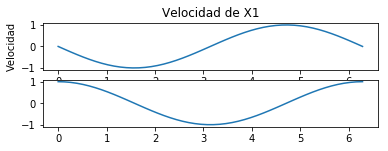

In [25]:
#PASO 4: VELOCIDAD DE X1
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)
    VX1 = np.zeros((50,0))
    VY1 = np.zeros((50,0))
    VX2 = np.zeros((50,0))
    VY2 = np.zeros((50,0))
    i=0
    for t in th:

        q[4] = t
        
        q = resuelve_prob_posicion (q, meca)
        qp = np.zeros ((5,1))
        #Velocidad del gdl. En una vuelta completa del angulo se cumple angulo=2*Pi*t
        qp[4]=1
        qp = resuelve_prob_velocidad (q,qp, meca)


        VX1 = np.append(VX1, qp[0])
        VY1 = np.append(VY1, qp[1])
        VX2 = np.append(VX2, qp[2])
        VY2 = np.append(VY1, qp[3])
        i=i+1
      
    plt.subplot(4,1,1)
    plt.plot(th,VX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X1')

    plt.subplot(4,1,2)
    plt.plot(th,VY1)

    
    plt.show()
    return 

grafica_velocidad (q,meca)


VY1=
array([ 1.        ,  0.99178998,  0.96729471,  0.92691642,  0.87131812,
        0.80141273,  0.7183481 ,  0.62348816,  0.51839052,  0.40478088,
        0.28452471,  0.15959664,  0.03204798, -0.09602691, -0.22252503,
       -0.34536928, -0.46254254, -0.57212084, -0.67230489, -0.76144965,
       -0.83809138, -0.9009716 , -0.94905783, -0.98156048, -0.99794585,
       -0.99794491, -0.98155767, -0.9490532 , -0.90096523, -0.83808336,
       -0.76144013, -0.67229401, -0.57210879, -0.46252952, -0.34535549,
       -0.2225107 , -0.09601228,  0.03206267,  0.15961114,  0.2845388 ,
        0.40479431,  0.51840308,  0.62349965,  0.71835832,  0.80142151,
        0.87132533,  0.92692193,  0.96729844,  0.99179185,  1.        ])


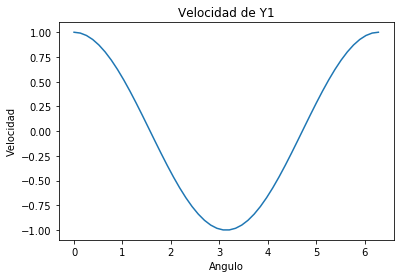

In [5]:
#PASO 4: VELOCIDAD DE Y1
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)
    VY1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        q = resuelve_prob_posicion (q, meca)
        qp = np.zeros ((5,1))
        #Velocidad del gdl. En una vuelta completa del angulo se cumple angulo=2*Pi*t
        qp[4]=1
        qp = resuelve_prob_velocidad (q,qp, meca)


        VY1 = np.append(VY1, qp[1])
   
        i=i+1
      
    print ("VY1=")
    pprint.pprint(VY1)
 
    plt.plot(th,VY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y1')

    plt.show()
    return 

grafica_velocidad (q,meca)


VX2=
array([-0.97578094, -0.94064481, -0.86229413, -0.75939495, -0.64892088,
       -0.54287465, -0.44786223, -0.36631311, -0.29807515, -0.24170582,
       -0.19529827, -0.1569237 , -0.1248243 , -0.09746564, -0.07351876,
       -0.05181073, -0.03126327, -0.01082924,  0.01056711,  0.03407775,
        0.06095235,  0.09251121,  0.13004264,  0.17460806,  0.22677253,
        0.28633141,  0.35213956,  0.42212577,  0.4934918 ,  0.56301322,
        0.6273349 ,  0.68319026,  0.72752662,  0.75755418,  0.77074751,
        0.76482544,  0.73773003,  0.68762376,  0.61292819,  0.51243859,
        0.38556577,  0.23277261,  0.0562732 , -0.13898992, -0.34423905,
       -0.54609578, -0.72702508, -0.86794903, -0.95315675, -0.97578002])


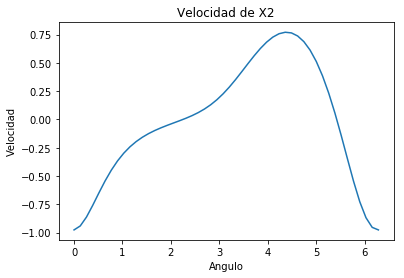

In [6]:
#PASO 4: VELOCIDAD DE X2
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VX2 = np.zeros((50,0)) 
    
    i=0
    for t in th:

        q[4] = t
        
        q = resuelve_prob_posicion (q,meca)
        qp = np.zeros((5,1))

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        qp = resuelve_prob_velocidad(q,qp, meca)


        VX2 = np.append(VX2, qp[2])

        i=i+1
      
    print ("VX2=")
    pprint.pprint(VX2)
 
    plt.plot(th,VX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X2')

    plt.show()
    return 

grafica_velocidad (q,meca)

VY2=
array([ 0.78125   ,  0.85908396,  0.89657817,  0.89471693,  0.86082499,
        0.80489821,  0.73644151,  0.66281302,  0.58888129,  0.51738828,
        0.44952158,  0.38543688,  0.32464603,  0.26627247,  0.20920559,
        0.15218983,  0.09388056,  0.03289622, -0.03210453, -0.10229024,
       -0.17844255, -0.26065315, -0.34797148, -0.43811605, -0.52742415,
       -0.61119187, -0.68439887, -0.74259436, -0.78261534, -0.8029133 ,
       -0.80348373, -0.78554942, -0.75117164, -0.70290071, -0.64350376,
       -0.57576048, -0.50229858, -0.42543826, -0.34702038, -0.26820218,
       -0.18922188, -0.10916516, -0.025825  ,  0.06416684,  0.16467014,
        0.27857426,  0.40559073,  0.54006192,  0.67035135,  0.78126103])


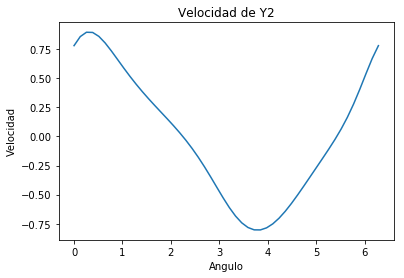

In [10]:
#PASO 4: VELOCIDAD DE Y2
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VY2 = np.zeros((50,0))
    
    i=0
    for t in th:

        q[4] = t
        
        q = resuelve_prob_posicion (q,meca)
        qp = np.zeros((5,1))

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        qp = resuelve_prob_velocidad(q, qp, meca)
        
        #VX1[0,i] = qp[0]

        VY2 = np.append(VY2, qp[3])
        i=i+1
      
    print ("VY2=")
    pprint.pprint(VY2)
 
    plt.plot(th,VY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y2')

    plt.show()
    return 

grafica_velocidad (q,meca)

### PASO 5: GRÁFICAS ACELERACIONES

Haremos el mismo procedimiento que para la velocidad, representando en celdas separadas la aceleración de cada coordenada.

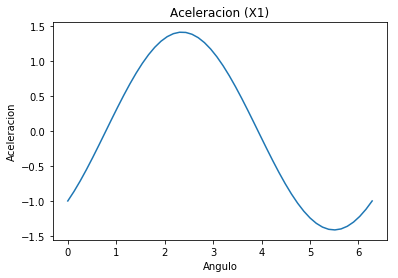

In [26]:
#PASO 5: ACELERACION DE X1

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)

    AX1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        q = resuelve_prob_posicion (q,meca)
        
        qp = np.zeros((5,1))
        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp = resuelve_prob_velocidad(q, qp, meca)
        
        qpp = np.zeros((5,1))
        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2
        qpp = resuelve_prob_aceleracion(q,qp, qpp, meca)
        
        AX1 = np.append(AX1, qpp[0])

        i=i+1

 
    plt.plot(th,AX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X1)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)


AY1=
array([-1.        , -1.11966743, -1.22094987, -1.30218426, -1.36203671,
       -1.39952446, -1.41403194, -1.40532095, -1.37353452, -1.31919459,
       -1.24319342, -1.14677895, -1.03153431, -0.89935183, -0.75240195,
       -0.59309759, -0.42405454, -0.2480485 , -0.06796948,  0.11322559,
        0.2925615 ,  0.46709353,  0.63395587,  0.79040862,  0.93388282,
        1.06202261,  1.17272395,  1.2641691 ,  1.33485653,  1.38362555,
        1.40967537,  1.41257826,  1.39228653,  1.3491334 ,  1.28382743,
        1.19744095,  1.09139243,  0.96742319,  0.82756882,  0.67412573,
        0.50961346,  0.33673331,  0.15832398, -0.02268503, -0.20332156,
       -0.38061953, -0.55166771, -0.71365749, -0.86392897, -1.00001469])


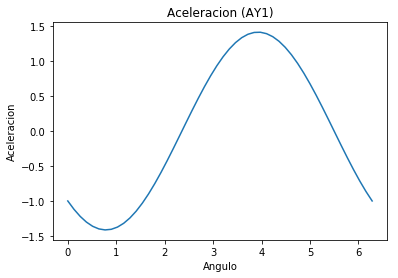

In [27]:
#PASO 5: ACELERACION DE Y1

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)


    AY1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        q = resuelve_prob_posicion (q,meca)
        
        qp = np.zeros((5,1))
        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp = resuelve_prob_velocidad(q, qp, meca)
        
        qpp = np.zeros((5,1))
        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2
        qpp = resuelve_prob_aceleracion(q,qp, qpp, meca)
        

        AY1 = np.append(AY1, qpp[1])

        i=i+1
      
    print ("AY1=")
    pprint.pprint(AY1)
 
    plt.plot(th,AY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (AY1)')

    plt.show()
    return 

grafica_aceleracion (q,meca)


AX2=
array([ 1.03828094,  1.40644643,  1.59346761,  1.61066564,  1.50510229,
        1.33230987,  1.13741129,  0.94906533,  0.78162068,  0.6398943 ,
        0.52346529,  0.42958077,  0.35481777,  0.29590979,  0.25009395,
        0.21521212,  0.18969676,  0.17250016,  0.16297807,  0.16070322,
        0.16516284,  0.17530185,  0.18894352,  0.20227142,  0.20972293,
        0.20463142,  0.18059739,  0.13304415,  0.06021405, -0.03677276,
       -0.15460224, -0.28871216, -0.43410981, -0.58590613, -0.73957908,
       -0.8910354 , -1.03652394, -1.17241027, -1.29477561, -1.39876346,
       -1.47758358, -1.52114378, -1.51451749, -1.43702093, -1.26362556,
       -0.97130441, -0.55208833, -0.02974847,  0.53120345,  1.0383324 ])


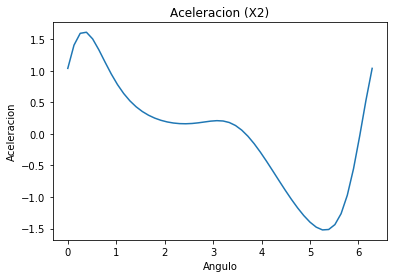

In [28]:
#PASO 5: ACELERACION DE X2

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)


    AX2 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        q = resuelve_prob_posicion (q,meca)
        
        qp = np.zeros((5,1))
        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp = resuelve_prob_velocidad(q, qp, meca)
        
        qpp = np.zeros((5,1))
        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2
        qpp = resuelve_prob_aceleracion(q,qp, qpp, meca)
        

        AX2 = np.append(AX2, qpp[2])

        i=i+1
      
    print ("AX2=")
    pprint.pprint(AX2)
 
    plt.plot(th,AX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X2)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)


AY2=
array([-0.03064928, -0.40537941, -0.76390779, -1.04637231, -1.22436662,
       -1.3010921 , -1.29838141, -1.24299628, -1.15833716, -1.06154499,
       -0.96373967, -0.87142439, -0.78798113, -0.71485296, -0.65234428,
       -0.60008837, -0.55724545, -0.52247328, -0.49369115, -0.46766696,
       -0.43952616, -0.40243452, -0.34790226, -0.26720369, -0.15399504,
       -0.00727917,  0.16693235,  0.35653066,  0.54646618,  0.72243335,
        0.87342463,  0.99260748,  1.07695898,  1.12637959,  1.14281414,
        1.12961693,  1.09120059,  1.03291876,  0.9610999 ,  0.88312021,
        0.80733826,  0.74258575,  0.6967325 ,  0.6737479 ,  0.66903568,
        0.66424114,  0.6254477 ,  0.51082377,  0.29043587, -0.03069038])


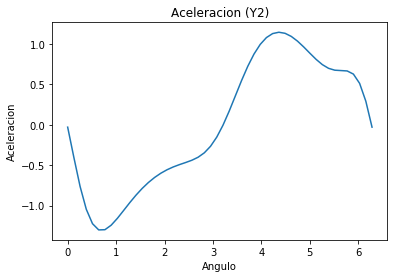

In [29]:
#PASO 5: ACELERACION DE Y2

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)


    AY2 = np.zeros((50,0))
    
    i=0
    for t in th:

        q[4] = t
        q = resuelve_prob_posicion (q,meca)
        
        qp = np.zeros((5,1))
        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp = resuelve_prob_velocidad(q, qp, meca)
        
        qpp = np.zeros((5,1))
        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2
        qpp = resuelve_prob_aceleracion(q,qp, qpp, meca)
        

        AY2 = np.append(AY2, qpp[3])
        i=i+1
      
    print ("AY2=")
    pprint.pprint(AY2)	
 
    plt.plot(th,AY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (Y2)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)
